# <b>CDiscount image classification challenge 

## 1.1 Introduction
Cdiscount.com is the largest non-food e-commerce company in France. The company has a wide variety of products which range from TVs to trampolines, the list of products is still rapidly growing. In the year 2017 when this competition was held, Cdiscount.com had over 30 million products up for sale. This is a rapid growth from 10 million products before 2 years. Ensuring that so many products are well classified is a challenging task. At that time, Cdiscount.com applied machine learning algorithms to the text description of the products in order to automatically predict their category. As those methods then seemed close to their maximum potential, Cdiscount.com believed that the next improvement will be through deep learning. So, they have conducted this Kaggle competition.

## 1.2 Source/Useful Links
* Source : https://www.kaggle.com/c/cdiscount-image-classification-challenge/overview

## 1.3 Business problem and constraints

We need a model that automatically classifies the products based on their images.  The problem here is that, one product can have one or several images. The dataset Cdiscount.com is making available is having almost 9 million products and more than 15 million images at 180x180 resolution and more than 5000 categories that we need to classify the products in to. There are 3 levels of product classifications where there are groups inside the groups and sub-groups and so on. <br>
* <b> Objective :</b> Here our objective is to predict the probability of given image belonging to a particular product category as correctly as possible.<br>
* <b> Constraints : </b> There is some constraint regarding the latency as they cannot wait all day as many products are listed in their website on daily basis. So, we need a model that classifies the posted product with the given image in a reasonable timeframe.


## 1.4	Machine Learning formulation of the business problem

Here given an image we need to perform a multi-class classification with 5000+ classes and predict the product category that the image belongs to as correctly as possible.

## 1.5 Dataset overview
The data is given in the form of BSON files, short for binary JSON files which are binary encoded serialization of the JSON-like documents, used with MongoDB. We need to read and process the BSON files to get the images.
File descriptions:
1. <b>	train.bson </b> : This file is huge with a size of 58.2GB and contains a list of 7Million dictionaries one per product. Each dictionary contains product id (key: _id), the category id of the product (key: category_id), and between 1-4 images, stored in a list (key: imgs). Each image list contains a single dictionary per image, which uses the format: {'picture': b'...binary string...'}. The binary string corresponds to a binary representation of the image in JPEG format. They have also provided an example of how to process this data.
2. <b>	test.bson </b> : This is also a huge file with a size of 14.5GB and contains a list of 1.7 million products in the same format as the train.bson, except there is no category_id included and this is the data that is used for evaluation for Kaggle and we need to create a submission file.
3. <b>	Category_names.csv </b> : This is a csv file which shows the hierarchy of the product classification. Each category_id has corresponding level1, level2 and level3 name, in French. The category_id corresponds to the category tree down to its lowest level. This hierarchical data may be useful, but it is not necessary for building models and making predictions.


## 1.6 Performance Metric

* The metric to measure the performance of the model was chosen by them to be <b> accuracy</b> because the need to correctly classify as many products as possible. 
* We can also take <b>multi-class log-loss</b> because it penalizes the model for every wrong prediction and also it uses the probability values directly to estimate the value.
* Here we cannot use plot the <b>Precision and recall</b> matrices even though it is classification simple due to sheer number of classes which are close to 5000, so it makes it impractical to visualize the matrices , but we can plot the values of the precision and recall for each class on a bar plot or count plot to get an idea of how the model is performing for each class and here we can expect the product classes to have unequal number of data points as that is always the case with the real world data.


## Exploratory data analysis

Here we have extracted the 1 Million images from the dataset and made a dataframe based on their given product_id and category_id. The code for the extraction is given in the pre-processing.ipynb notebook.

In [1]:
# read the dataframe with the image names and the category ids of each image
import pandas as pd

df_1=pd.read_csv('train_data.csv')
df_1.head()

,image_path,product_id,category_id
0,train_images/0_1000010653.png,0,1000010653
1,train_images/7_1000004079.png,7,1000004079
2,train_images/9_1000018290.png,9,1000018290
3,train_images/15_1000015309.png,15,1000015309
4,train_images/19_1000014287.png,19,1000014287


In [2]:
#display the number of images
df_1.shape

(999999, 3)

* Here we have another csv file which has the macro and micro categories as well for each given category_id of the image.
* The original csv file was given in french which we have translated to english as shown below. The translation code can be found in translation.ipynb notebook.

In [3]:
#read the csv file containing the actual names of the category
df_2=pd.read_csv('translated_category_names.csv')
df_2.head()

,category_id,category_level1,category_level2,category_level3,translated_category_level3,translated_category_level2,translated_category_level1
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,PREPAID MULTIMEDIA CARD,PREPAID CARD,Subscription / Services
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,Smoking shelter,Urban development,Urban Processing - Roads
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,Bike shelter - motorcycle shelter,Urban development,Urban Processing - Roads
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,WATER FOUNTAIN,Urban development,Urban Processing - Roads
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,Exterior Information Panel,Signaletic,Urban Processing - Roads


* Here we have the class labels in the multi-level hierarchy where class level 1 is in the top and the class level 3 is the bottom. Here class level 1 is having sub categories as class level 2 and which inturn has categories in level 3.

In [4]:
# count the number of unique category_ids
df_2.shape

(5270, 7)

* There are 5270 unique category of images in the 3rd level and which is given in the numerical format in terms of category id.
* Hence we have a large multi-class classsfication problem with 5270 unique classes.

## Add the translated category names to the train data for interpretation

In [5]:
# Loop through the train data and find the corresponding category names in the category names dataframe and add them to the train data
from tqdm import tqdm

ids = df_1['category_id'].values
category_level1_names=[]
category_level2_names=[]
category_level3_names=[]

for id in tqdm(ids):
    row=df_2[df_2['category_id']==id]
    category_level3_names.append(row['translated_category_level3'].values[0])
    category_level2_names.append(row['translated_category_level2'].values[0])
    category_level1_names.append(row['translated_category_level1'].values[0])

100%|██████████| 999999/999999 [05:05<00:00, 3272.11it/s]


In [6]:
#add the names to the dataframe
df_1['category_level3']=category_level3_names
df_1['category_level2']=category_level2_names
df_1['category_level1']=category_level1_names
df_1.head()

,image_path,product_id,category_id,category_level3,category_level2,category_level1
0,train_images/0_1000010653.png,0,1000010653,Telephone Case - Bumper Telephone,Telephone accessory,Telephony - GPS
1,train_images/7_1000004079.png,7,1000004079,Charger - AC Adapter - Cigarette Lighter - Solar,Connectivity - Food,COMPUTER SCIENCE
2,train_images/9_1000018290.png,9,1000018290,Classical music CD,CD,MUSIC
3,train_images/15_1000015309.png,15,1000015309,Other books,Other books,LIBRARY
4,train_images/19_1000014287.png,19,1000014287,SOCIOLOGY,SOCIAL SCIENCE,LIBRARY


In [ ]:
#save the dataframe to the csv file

df_1.to_csv('train_data_with_class_labels.csv',index=False)

## <b> 1. Exploratory data analysis of the images based on category level 3 as class labels

In [65]:
import pandas as pd

#get the saved dataframe with translated names
df_1=pd.read_csv('train_data_with_class_labels.csv')
df_1.head()

,image_path,product_id,category_id,category_level3,category_level2,category_level1
0,train_images/0_1000010653.png,0,1000010653,Telephone Case - Bumper Telephone,Telephone accessory,Telephony - GPS
1,train_images/7_1000004079.png,7,1000004079,Charger - AC Adapter - Cigarette Lighter - Solar,Connectivity - Food,COMPUTER SCIENCE
2,train_images/9_1000018290.png,9,1000018290,Classical music CD,CD,MUSIC
3,train_images/15_1000015309.png,15,1000015309,Other books,Other books,LIBRARY
4,train_images/19_1000014287.png,19,1000014287,SOCIOLOGY,SOCIAL SCIENCE,LIBRARY


In [66]:
#Here we can count the number of images belonging to each category by using groupby
count_df=df_1.groupby(['category_level3']).count()

#display the counts
count_df['product_id']

category_level3
- game of                                                                                                 38
0-3 years - Awakening                                                                                    809
12 years - More than 12 years - Teenagers                                                                870
2 Wheel Sleeve - Apron for 2 Wheels - Skirt for 2 Wheels                                                  29
2DS console                                                                                                6
                                                                                                        ... 
Xylophone - Carillon - Chromatic Bar - Boomophone - Boomwhacker - Metallophone - Balafon - Glockspiel      3
YEAST                                                                                                     15
Yogurtiere - Cheager                                                                                      19
You

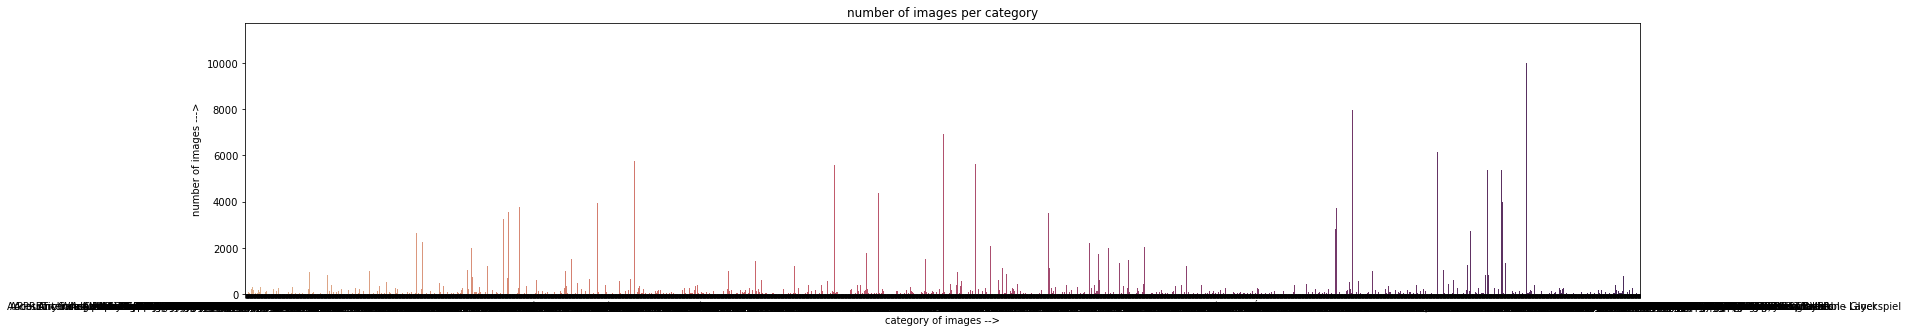

In [9]:
# Here we plot the counts of images belonging to various level-3 categories for comparison between them

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
sns.barplot(y=count_df['product_id'],x=count_df.index,palette='flare')
plt.ylabel('number of images --->')
plt.xlabel('category of images -->')
plt.title('number of images per category')
plt.show()

### Observations
* Here we can see that the distribution of the images in the classes is extremely skewed with some classes having very large number of images like as high as 10000 images and some are having very less number of images as low as 1.
* There is class imbalance , this indicates that we need to perform image augmebntation for the classes which have less number of images ,so that our network would learn more properly.

### Let us sort the count values and plot the distribution using the probability density plot

In [67]:
#Here we are sorting so that we can have a look at the actual values as shown below
sorted_counts=count_df['product_id'].sort_values(ascending=False)
sorted_counts

category_level3
CD Pop Rock - CD Rock India        11183
Toner - Toner Recovery             10004
PRINTER CARTRIDGE                   9961
Other books                         9392
FRENCH LITERATURE                   9126
                                   ...  
Pilot pants                            1
Aluminum Sheet for Chicha              1
Articulation - Shoulder - Knees        1
WASTE COMPACTOR                        1
Toast holder                           1
Name: product_id, Length: 5186, dtype: int64

### Let us see some of the images of the products with highest number of images

In [68]:
import numpy as np
top5_classes=np.array(sorted_counts[:5].index)

print(top5_classes)

['CD Pop Rock - CD Rock India' 'Toner - Toner Recovery'
 'PRINTER CARTRIDGE' 'Other books' 'FRENCH LITERATURE']


product images for class category CD Pop Rock - CD Rock India


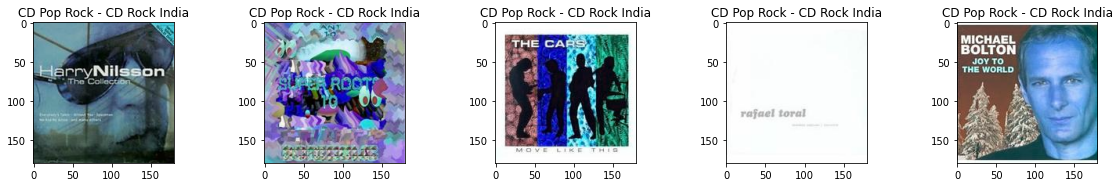

product images for class category Toner - Toner Recovery


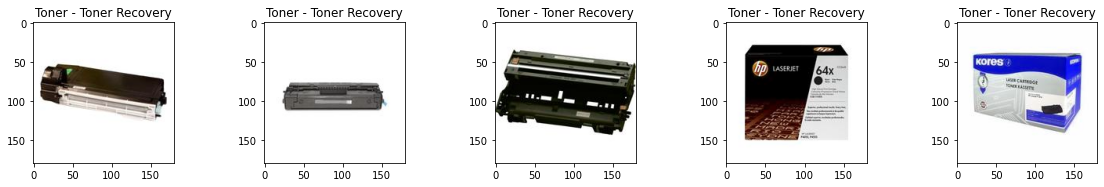

product images for class category PRINTER CARTRIDGE


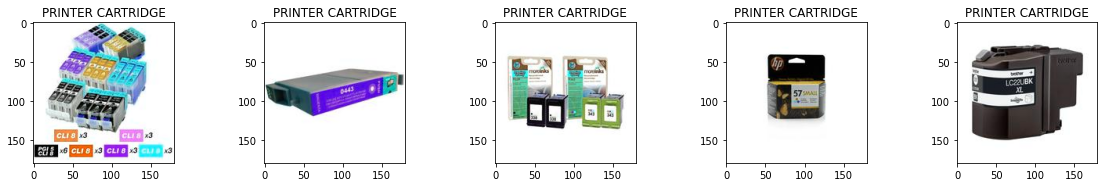

product images for class category Other books


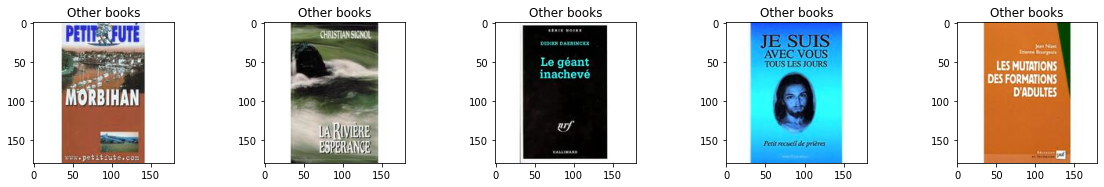

product images for class category FRENCH LITERATURE


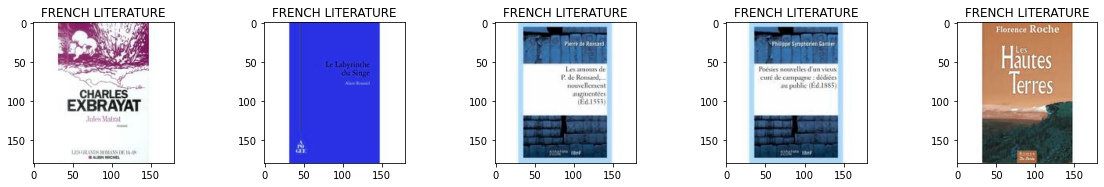

In [69]:
#display the images
import matplotlib.pyplot as plt
import cv2
image_paths=[]
for cl_name in top5_classes:
    image_paths.append(df_1[df_1['category_level3']==cl_name]['image_path'].values[0:5])

count=0
for j,category in enumerate(image_paths):
    plt.figure(figsize=(20,15))
    for i,path in enumerate(category):
        plt.subplot(5,5,count+1)
        image=cv2.imread(path)
        plt.title(top5_classes[j])
        plt.imshow(image)
        count+=1
    print("product images for class category",top5_classes[j])
    plt.show()

### Observations
* It seems that the Music CD's and the printer parts are occupying the majority of the store. They are followed by the books which are also in the comparable counts to the CD's.
* As we know that the books and the Music CD's are one of the categories of images that are difficult to classify because they contain picture on the covers which imply another object which basically misleads the algorithm to predict it as another category.

### Let us how many of the data points have only 1 image for product

In [7]:
one_image_products=[]
sum=0
for j,row in enumerate(sorted_counts):
    if row==1:
        sum+=1
        one_image_products.append(sorted_counts.index[j])
       
print('number of single image data points are :',sum)


number of single image data points are : 116


### Let us see how the images of these rare products look like

In [29]:
# Get any random 5 products class names with 1 image
image_names = one_image_products[21:26]
print(image_names)

['Window for connected watch - Screen for connected watch', 'Bucket', 'Poker - Fireplace Clamp - Buche Clamp', 'Disposable bed linen', 'Prepares meat']


product images for category wth only 1 image 


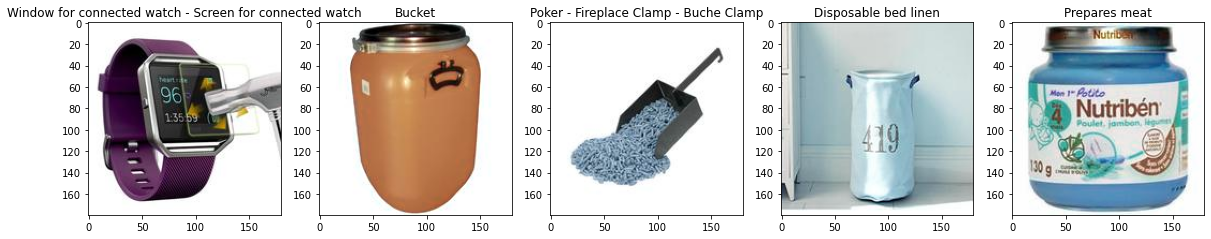

In [32]:
#display the images
import matplotlib.pyplot as plt
import cv2
image_paths=[]
for cl_name in image_names:
    image_paths.append(df_1[df_1['category_level3']==cl_name]['image_path'].values[0])

plt.figure(figsize=(20,10))
for i,path in enumerate(image_paths):
    plt.subplot(1,5,i+1)
    image=cv2.imread(path)
    plt.title(image_names[i])
    plt.imshow(image)

print("product images for category wth only 1 image ")
plt.show()
    

### Let us see how many products have less than 5 images

In [12]:
lessthan5_image_products=[]
sum=0
for j,row in enumerate(sorted_counts):
    if row<=5:
        sum+=1
        lessthan5_image_products.append(sorted_counts.index[j])
        
print('number of products with less than 5 images are :',sum)

number of products with less than 5 images are : 760


#### Plot the density plot

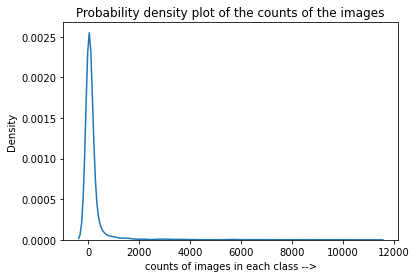

In [57]:
sns.kdeplot(sorted_counts.values)
plt.xlabel('counts of images in each class -->')
plt.title('Probability density plot of the counts of the images')
plt.show()

### Observations
* As seen above, we can say that most of the product categories have less than 500 images roughly and most of the values are close to single digit counts.

### Let us print the percentiles to look at the actual count values across the dataset

Print the 0 to 100th percentiles with gap of 10

In [56]:
import numpy as np

for i in range(0,110,10):
    print(i, " th percentile value is ",np.percentile(sorted_counts,i))

0  th percentile value is  1.0
10  th percentile value is  4.0
20  th percentile value is  7.0
30  th percentile value is  12.0
40  th percentile value is  19.0
50  th percentile value is  29.0
60  th percentile value is  45.0
70  th percentile value is  76.0
80  th percentile value is  141.0
90  th percentile value is  336.0
100  th percentile value is  11183.0


### Observations
* Here we can see that 90 percent of the classes have less than 330 images and the class with highest number of images has 11183 images.

Print the 90 to 100th percentile values and the percentiles between 99 to 100.

In [58]:
for i in range(90,101,1):
    print(i, " th percentile value is ",np.percentile(sorted_counts.values,i))

90  th percentile value is  336.0
91  th percentile value is  371.35000000000036
92  th percentile value is  414.0
93  th percentile value is  480.0
94  th percentile value is  592.0
95  th percentile value is  710.75
96  th percentile value is  937.3999999999896
97  th percentile value is  1272.249999999999
98  th percentile value is  1973.5000000000064
99  th percentile value is  3534.3499999999967
100  th percentile value is  11183.0


In [30]:
for j in range(11):
    i=99 + (j/10)
    print(i, " th percentile value is ",np.percentile(sorted_counts.values,i))

99.0  th percentile value is  3526.9200000000055
99.1  th percentile value is  3706.1840000000084
99.2  th percentile value is  3943.0720000000147
99.3  th percentile value is  4382.2720000000045
99.4  th percentile value is  5456.960000000021
99.5  th percentile value is  5628.720000000001
99.6  th percentile value is  5956.968000000023
99.7  th percentile value is  6492.26400000001
99.8  th percentile value is  7635.7200000000375
99.9  th percentile value is  8716.528000000068
100.0  th percentile value is  11183.0


### Observations 
* Here we can conclude that class labels based on category level3 have extremely skewed which is expected because not all the items are equally important among the usage for various people.
* Here one approach is to perform image augmentations for the minority class labels because we already have a huge amount of data, so adding more images will definetely result in more resource consumption.
* We can assign class labels to the classes based on their strengths, and we cn remove the classes with very less number of images like 1 image , so that the class weights are not that skewed as the class images themselves.

## <b> 2. Exploratory data analysis of the images based on category level 2 as class labels

In [71]:
#Here we can count the number of images belonging to each category by using groupby
count_df=df_1.groupby(['category_level2']).count()

#display the counts
count_df['product_id']

category_level2
ACCESS CONTROL                       33
AIR TREATMENT                       684
ALCOHOL                             345
APERITIF                             77
Active components                   152
                                   ... 
Water Games - Beach Games           846
Water Sport - Water Slip            419
Watering                           1213
Weighing utensils - Measurement     384
Wetting                              80
Name: product_id, Length: 481, dtype: int64

* Here we can see that we have 481 unique category of level2 products as compared to level3 categories which had 5000+ in number.

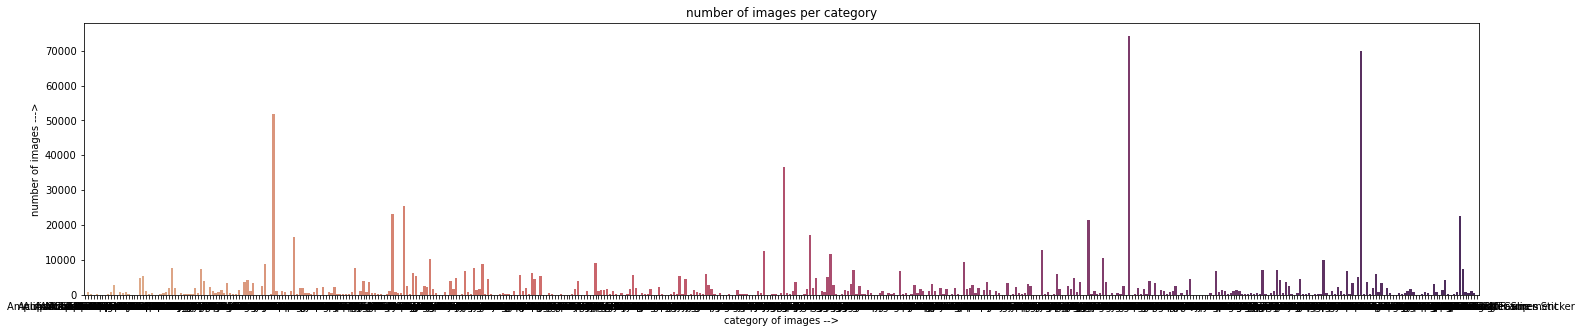

In [61]:
# Here we plot the counts of images belonging to various level-2 categories for comparison between them

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
sns.barplot(y=count_df['product_id'],x=count_df.index,palette='flare')
plt.ylabel('number of images --->')
plt.xlabel('category of images -->')
plt.title('number of images per category')
plt.show()

### Observations
* Here we can see that the distribution of the images in the classes for level2 is also extremely skewed with some classes having very large number of images like as high as 70000 images and some are having very less number of images as low as 1. This is more skewed than the category level 3.

### Let us sort the count values and plot the distribution using the probability density plot

In [72]:
#Here we are sorting so that we can have a look at the actual values as shown below
sorted_counts=count_df['product_id'].sort_values(ascending=False)
sorted_counts

category_level2
ROOMS                               74222
Telephone accessory                 69798
CD                                  51700
JEWELRY                             36619
Connectivity - Food                 25547
                                    ...  
Tools of the beekeeper                  1
Dog sport                               1
LNPR - new book at reduced price        1
ICE                                     1
PIERCING                                1
Name: product_id, Length: 481, dtype: int64

### Let us see some of the images with highest number of images

In [48]:
import numpy as np
top5_classes=np.array(sorted_counts[:5].index)

print(top5_classes)

['ROOMS' 'Telephone accessory' 'CD' 'JEWELRY' 'Connectivity - Food']


product images for class category ROOMS


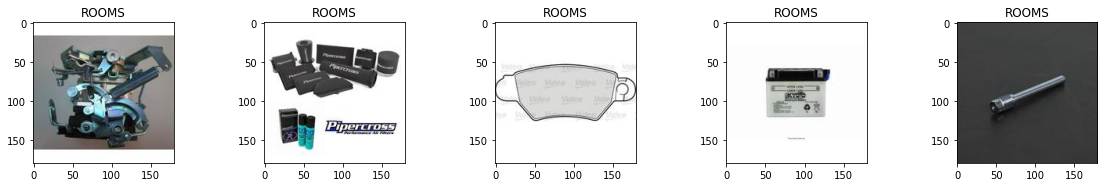

product images for class category Telephone accessory


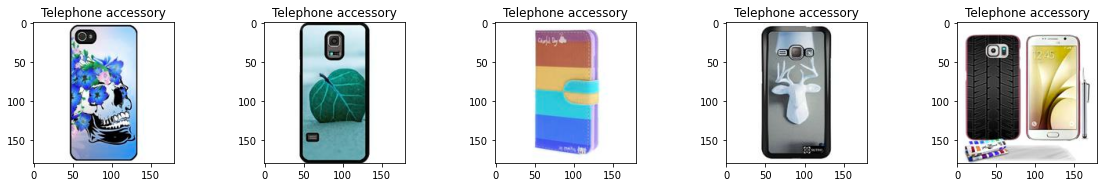

product images for class category CD


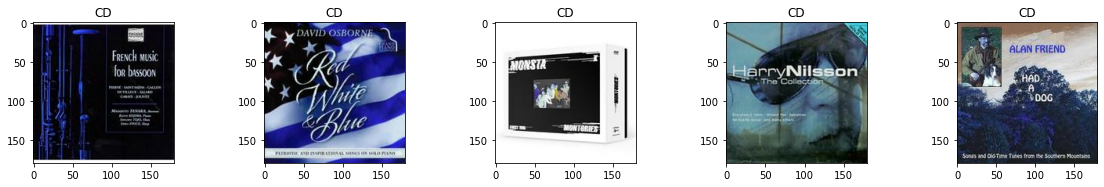

product images for class category JEWELRY


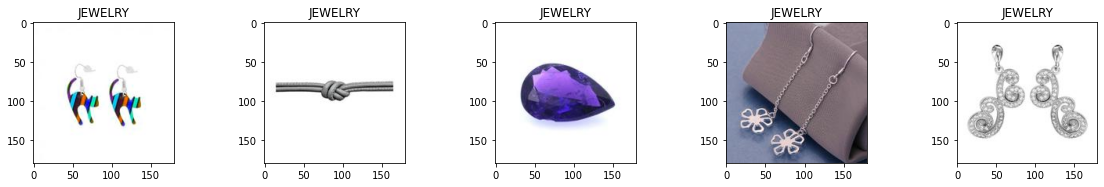

product images for class category Connectivity - Food


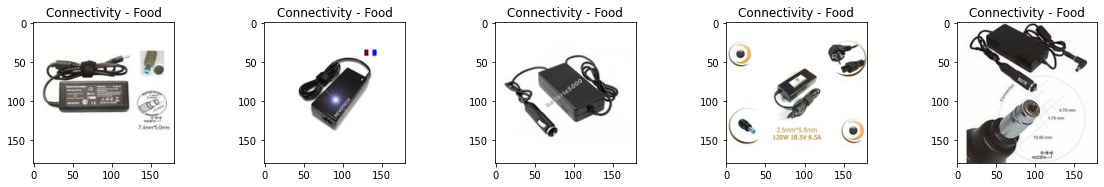

In [64]:
#display the images
import matplotlib.pyplot as plt
import cv2
image_paths=[]
for cl_name in top5_classes:
    image_paths.append(df_1[df_1['category_level2']==cl_name]['image_path'].values[0:5])

count=0
for j,category in enumerate(image_paths):
    plt.figure(figsize=(20,15))
    for i,path in enumerate(category):
        plt.subplot(5,5,count+1)
        image=cv2.imread(path)
        plt.title(top5_classes[j])
        plt.imshow(image)
        count+=1
    print("product images for class category",top5_classes[j])
    plt.show()


### Observations
* It seems that here ROOMS and the "telephone accessory" are occupying the majority of the store. They are followed by the music CD's.
* Here we can also see that we have some extermely rare products such as some category like Tools of the bee keeper which are for the niche of the population for specific needs etc.

### Let us see how many product categories have only 1 image for them

In [78]:
one_image_products=[]
sum=0
for j,row in enumerate(sorted_counts):
    if row==1:
        sum+=1
        one_image_products.append(sorted_counts.index[j])
       
print('number of single image classes of level 2 are :',sum)


number of single image classes of level 2 are : 6


### Let us see how the images of these rare products look like

In [75]:
# Get the class names with 1 image
image_names = one_image_products
print(image_names)

['UROLOGY', 'Tools of the beekeeper', 'Dog sport', 'LNPR - new book at reduced price', 'ICE', 'PIERCING']


product images for category wth only 1 image 


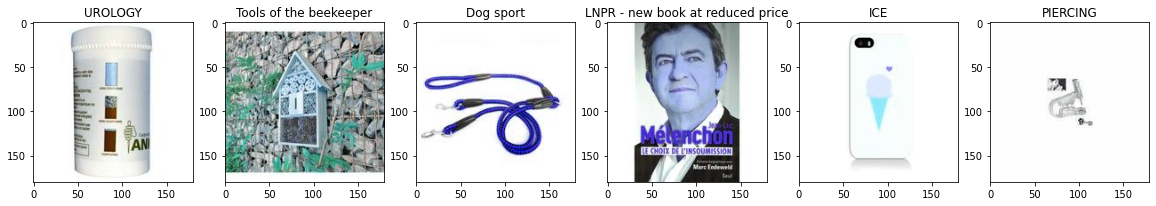

In [77]:
#display the images
import matplotlib.pyplot as plt
import cv2
image_paths=[]
for cl_name in image_names:
    image_paths.append(df_1[df_1['category_level2']==cl_name]['image_path'].values[0])

plt.figure(figsize=(20,10))
for i,path in enumerate(image_paths):
    plt.subplot(1,6,i+1)
    image=cv2.imread(path)
    plt.title(image_names[i])
    plt.imshow(image)

print("product images for category wth only 1 image ")
plt.show()
    

#### Plot the density plot

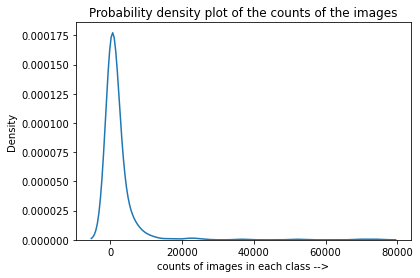

In [64]:
sns.kdeplot(sorted_counts.values)
plt.xlabel('counts of images in each class -->')
plt.title('Probability density plot of the counts of the images')
plt.show()

### Observations
* Here also we can see the similar distribution is very similar to the previous observation where most of the product categories of level 2 are having less than 500 images. This will be more clear if we actually print the percentiles.

### Let us print the percentiles to look at the actual count values across the dataset

Print the 0 to 100th percentiles with gap of 10

In [65]:
import numpy as np

for i in range(0,110,10):
    print(i, " th percentile value is ",np.percentile(sorted_counts,i))

0  th percentile value is  1.0
10  th percentile value is  21.0
20  th percentile value is  63.0
30  th percentile value is  134.0
40  th percentile value is  257.0
50  th percentile value is  466.0
60  th percentile value is  798.0
70  th percentile value is  1291.0
80  th percentile value is  2279.0
90  th percentile value is  4705.0
100  th percentile value is  74222.0


### Observations
* Here we can see that 90 percent of the classes have less than 4000 images and the class with highest number of images has roughly 74000+ images.

Print the 90 to 100th percentile values and the percentiles between 99 to 100.

In [67]:
for i in range(90,101,1):
    print(i, " th percentile value is ",np.percentile(sorted_counts.values,i))

90  th percentile value is  4705.0
91  th percentile value is  5135.800000000001
92  th percentile value is  5513.4000000000015
93  th percentile value is  6136.600000000005
94  th percentile value is  6819.999999999999
95  th percentile value is  7339.0
96  th percentile value is  8565.999999999958
97  th percentile value is  10208.199999999993
98  th percentile value is  14350.599999999911
99  th percentile value is  23619.799999999974
100  th percentile value is  74222.0


In [66]:
for j in range(11):
    i=99 + (j/10)
    print(i, " th percentile value is ",np.percentile(sorted_counts.values,i))

99.0  th percentile value is  23619.799999999974
99.1  th percentile value is  24776.120000000017
99.2  th percentile value is  27318.519999999648
99.3  th percentile value is  32633.07999999985
99.4  th percentile value is  38428.720000000925
99.5  th percentile value is  45667.60000000034
99.6  th percentile value is  53147.83999999971
99.7  th percentile value is  61834.88000000004
99.8  th percentile value is  69974.9600000001
99.9  th percentile value is  72098.48000000017
100.0  th percentile value is  74222.0


### Observations 
* Here we can conclude that class labels based on category level 2 have extremely skewed which is expected because not all the items are equally important among the usage for various people.
* Here there are only 6 classes with one image per category as opposed to the category level2 where there were 116 such classes. We could remove the classes and proceed for classification if we want to use these level of class labels.

## <b> 3. Exploratory data analysis of the images based on category level 1 as class labels

In [79]:
#Here we can count the number of images belonging to each category by using groupby
count_df=df_1.groupby(['category_level1']).count()

#display the counts
count_df['product_id']

category_level1
AUTO MOTO                                    109964
Art of the Table - Culinary Articles          26947
BEDDING                                        5889
BEEKEEPING                                        1
Box gift box                                    130
COMPUTER SCIENCE                             100466
CONDITIONING                                    916
Creative Leisure - Fine Arts - Stationery     16956
DIY - Tools - Hardware                        53158
DVD - Blu-ray                                 10028
Deco - Linen - Luminaire                      82079
Drugstore                                      3574
ELECTRONIC                                     2889
FRESH PRODUCTS                                   17
FROZEN PRODUCTS                                   1
FURNITURE                                     18784
Funeral                                          33
GAMES TOYS                                    43446
GROCERY STORE                                  3

In [71]:
count_df.shape[0]

49

* Here we can see that we have 49 unique category of level1 products which are less than level 2 and level 1 which is expected because it is highest level of categorizations which means it is as broad as possible.

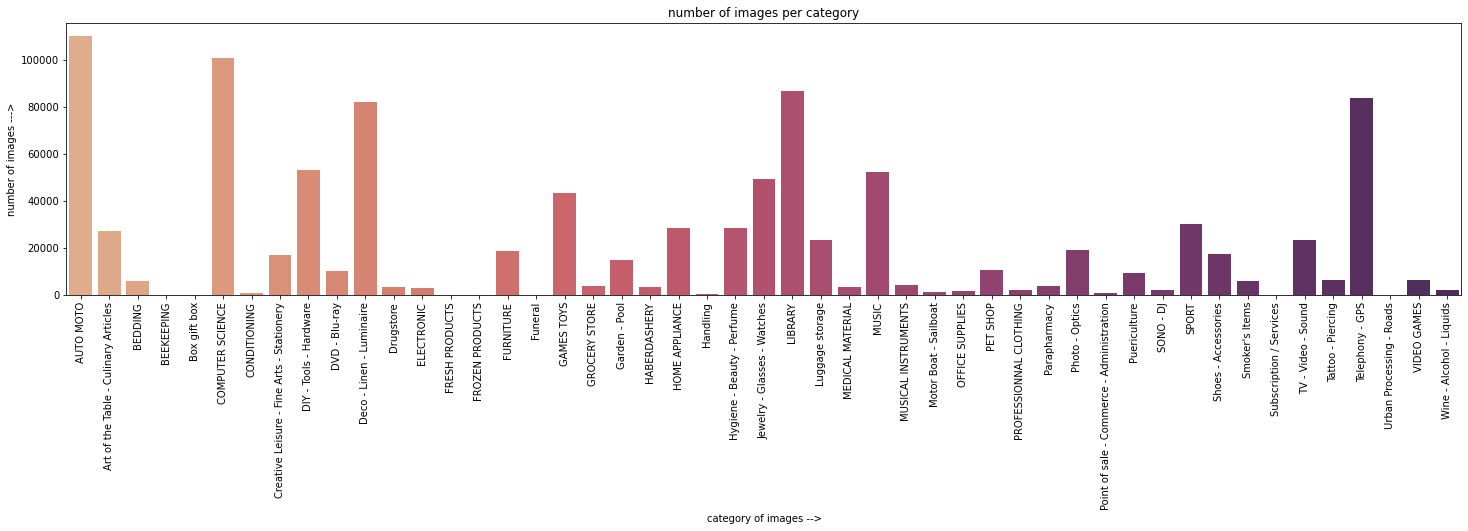

In [73]:
# Here we plot the counts of images belonging to various level-1 categories for comparison between them

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(25,5))
sns.barplot(y=count_df['product_id'],x=count_df.index,palette='flare')
plt.ylabel('number of images --->')
plt.xlabel('category of images -->')
plt.xticks(rotation=90)
plt.title('number of images per category')
plt.show()

### Observations
* Here we can see that the distribution of the images in the classes for level1 is as skewed as it can get which is more than the level 1 and level 2 also with some classes having very large number of images like as high as 100,000 images and some are having very less number of images as low as 1.

### Let us sort the count values and plot the distribution using the probability density plot

In [80]:
#Here we are sorting so that we can have a look at the actual values as shown below
sorted_counts=count_df['product_id'].sort_values(ascending=False)
sorted_counts


category_level1
AUTO MOTO                                    109964
COMPUTER SCIENCE                             100466
LIBRARY                                       86765
Telephony - GPS                               83697
Deco - Linen - Luminaire                      82079
DIY - Tools - Hardware                        53158
MUSIC                                         52374
Jewelry - Glasses - Watches                   49445
GAMES TOYS                                    43446
SPORT                                         30027
Hygiene - Beauty - Perfume                    28585
HOME APPLIANCE                                28278
Art of the Table - Culinary Articles          26947
Luggage storage                               23510
TV - Video - Sound                            23509
Photo - Optics                                19032
FURNITURE                                     18784
Shoes - Accessories                           17440
Creative Leisure - Fine Arts - Stationery     16

### Let us see the images of the top 5 classes of level 1 

In [81]:
import numpy as np
top5_classes=np.array(sorted_counts[:5].index)

print(top5_classes)

['AUTO MOTO' 'COMPUTER SCIENCE' 'LIBRARY' 'Telephony - GPS'
 'Deco - Linen - Luminaire']


product images for class category AUTO MOTO


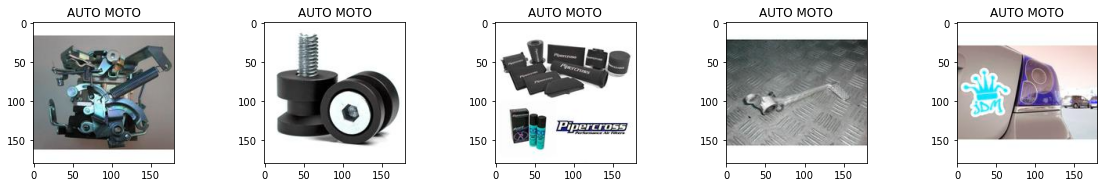

product images for class category COMPUTER SCIENCE


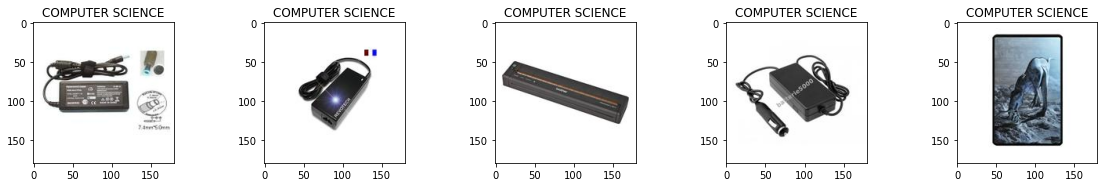

product images for class category LIBRARY


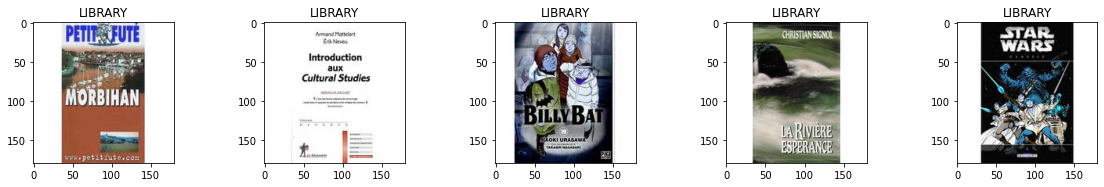

product images for class category Telephony - GPS


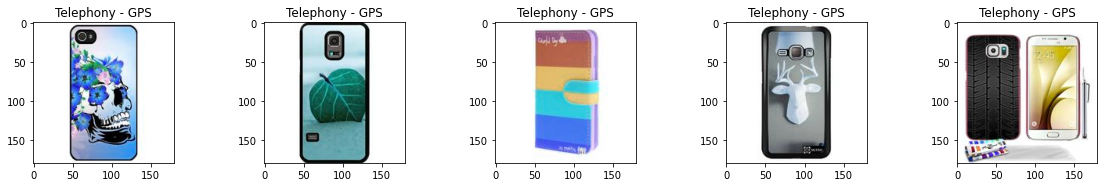

product images for class category Deco - Linen - Luminaire


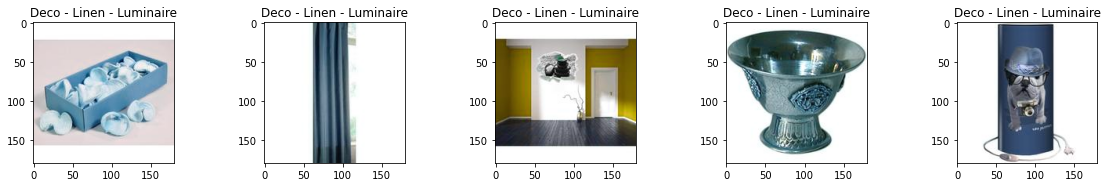

In [82]:
#display the images
import matplotlib.pyplot as plt
import cv2
image_paths=[]
for cl_name in top5_classes:
    image_paths.append(df_1[df_1['category_level1']==cl_name]['image_path'].values[0:5])

count=0
for j,category in enumerate(image_paths):
    plt.figure(figsize=(20,15))
    for i,path in enumerate(category):
        plt.subplot(5,5,count+1)
        image=cv2.imread(path)
        plt.title(top5_classes[j])
        plt.imshow(image)
        count+=1
    print("product images for class category",top5_classes[j])
    plt.show()


### Observations
* It seems that here Auto motive parts category is having the highest number of images in it followed by computer accessories and hygiene and LIBRARY which mostly means books etc.
* Here we can also see that we have some extermely rare products such as some category like Bee keeping and frozen products which are for the niche of the population for specific needs etc. This bee keeeping equipment category we have seen in the category level 3 also.

### Let us see how many product categories have only 1 image for them

In [83]:
one_image_products=[]
sum=0
for j,row in enumerate(sorted_counts):
    if row==1:
        sum+=1
        one_image_products.append(sorted_counts.index[j])
       
print('number of single image classes of level 1 are :',sum)


number of single image classes of level 1 are : 2


### Let us see how the images of these rare products look like

In [84]:
# Get the class names with 1 image
image_names = one_image_products
print(image_names)

['FROZEN PRODUCTS', 'BEEKEEPING']


product images for category class level 1 with only 1 image 


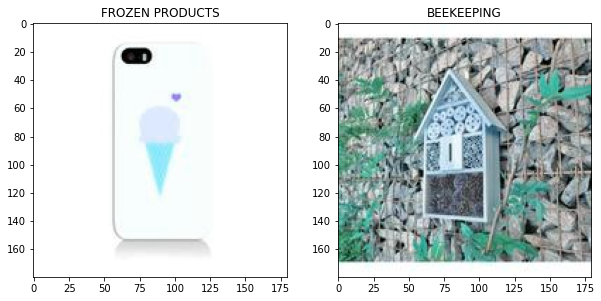

In [87]:
#display the images
import matplotlib.pyplot as plt
import cv2
image_paths=[]
for cl_name in image_names:
    image_paths.append(df_1[df_1['category_level1']==cl_name]['image_path'].values[0])

plt.figure(figsize=(10,7))
for i,path in enumerate(image_paths):
    plt.subplot(1,2,i+1)
    image=cv2.imread(path)
    plt.title(image_names[i])
    plt.imshow(image)

print("product images for category class level 1 with only 1 image ")
plt.show()

#### Plot the density plot

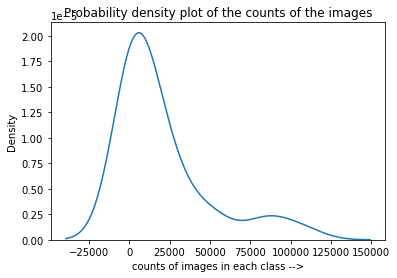

In [76]:
sns.kdeplot(sorted_counts.values)
plt.xlabel('counts of images in each class -->')
plt.title('Probability density plot of the counts of the images')
plt.show()

### Observations
* Here also we can see the similar distribution but the skewness is much less than the previous level 1 and level 2 categories and here most of the product categories of level 1 are having less than 1000 images. This will be more clear if we actually print the percentiles.
* Here as we have seen, that the classes with only one product can be removed a straight up outliers because they are not at all useful for classification , and one image among them is straight up wrongly labelled as ICE which is actually a phone cover.

### Let us print the percentiles to look at the actual count values across the dataset

Print the 0 to 100th percentiles with gap of 10

In [77]:
import numpy as np

for i in range(0,110,10):
    print(i, " th percentile value is ",np.percentile(sorted_counts,i))

0  th percentile value is  1.0
10  th percentile value is  110.60000000000007
20  th percentile value is  1083.4000000000003
30  th percentile value is  2494.7999999999993
40  th percentile value is  3697.000000000001
50  th percentile value is  6337.0
60  th percentile value is  13879.199999999988
70  th percentile value is  21718.199999999975
80  th percentile value is  29161.800000000007
90  th percentile value is  58942.200000000084
100  th percentile value is  109964.0


### Observations
* Here we can see that 90 percent of the classes have less than 50000 images and the class with highest number of images has roughly 100000+ images which is double than the 90% of the product categories listed above.

Print the 90 to 100th percentile values.

In [78]:
for i in range(90,101,1):
    print(i, " th percentile value is ",np.percentile(sorted_counts.values,i))

90  th percentile value is  58942.200000000084
91  th percentile value is  72824.28
92  th percentile value is  82337.88
93  th percentile value is  83114.52
94  th percentile value is  84065.15999999999
95  th percentile value is  85537.79999999999
96  th percentile value is  87861.07999999997
97  th percentile value is  94437.56000000003
98  th percentile value is  100845.92
99  th percentile value is  105404.95999999996
100  th percentile value is  109964.0


### Observations 
* Here we can conclude that class labels based on category level 1 are less skewed  than the remaining 2 categories which is evident from the distribution.
* Still this also shows the nature of the consumer products in general where some products are very useful and most of the products are not used by everyone but have moderate usage across wide range of demographic population.

## Final Conclusions
* Here basically we have extreme class imbalance where we can augment the images of the classes which have less number of images while training the models.
* Here the models could be designed for prediction of the class labels as category level3 as it is the actual objective of the problem.
* We can use the category levels 1 and 2 while comparison of the results for interpretation where we can check if the model predicts the category 3 wrong , then we could check if it has atleast predicted the category level 2 as correct etc. we could also check for category level 1's correctness where we could get insight about the model performance and between which classes it is confusing and between which products.
* Here as the number of classes are very large, we cannot interpret the results using the confusion matrix because it will simply be very huge and cannot be visualized. But we can compute the precision and recall values for each class and print them etc to see which class is dominating the result.